原文链接 https://cloud.tencent.com/developer/article/1924554

这是一个单变量LSTM模型, 分析了sh.600010并作出预测, 
还需要找到适合进行模型评估的方法, 好与其他股票对比选择
还可以进一步探索构建多变量模型的方法

导包
调整目录

In [1]:
import os
import pandas as pd
while os.getcwd().split('\\')[-1] != "Data_Analyst_FJNU":
    os.chdir('..')


切换到GPU训练

In [8]:
import tensorflow as tf

# 显示可用的 GPU 设备
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


Num GPUs: 0


读取数据

In [2]:

stock_data = pd.read_csv('./Data/history_A_stock_k_data/sh.600010.csv')
stock_data.head()

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST
0,2001-03-09,sh.600010,6.80,6.80,6.36,6.40,5.18,184839687,1.199614e+09,3,52.811339,1,23.552130,0
1,2001-03-12,sh.600010,6.38,6.43,6.31,6.37,6.40,21713538,1.382885e+08,3,6.203868,1,-0.468753,0
2,2001-03-13,sh.600010,6.40,6.56,6.40,6.51,6.37,27308195,1.777207e+08,3,7.802341,1,2.197808,0
3,2001-03-14,sh.600010,6.51,6.56,6.50,6.53,6.51,12919592,8.432932e+07,3,3.691312,1,0.307219,0
4,2001-03-15,sh.600010,6.53,6.65,6.48,6.59,6.53,23845329,1.564755e+08,3,6.812951,1,0.918835,0


数据集探索

时间序列 date	
使用变量 open	high	low	close	preclose	volume

In [3]:
stock_data = stock_data [['date','open','high','low','close','preclose','volume']]
stock_data['date'] = pd.to_datetime(stock_data['date'].apply(lambda x: x.split()[0]))
stock_data.set_index('date',drop=True,inplace=True)
stock_data.head()

,open,high,low,close,preclose,volume
date,,,,,,
2001-03-09,6.80,6.80,6.36,6.40,5.18,184839687
2001-03-12,6.38,6.43,6.31,6.37,6.40,21713538
2001-03-13,6.40,6.56,6.40,6.51,6.37,27308195
2001-03-14,6.51,6.56,6.50,6.53,6.51,12919592
2001-03-15,6.53,6.65,6.48,6.59,6.53,23845329


可视化开盘价和收盘价

C:\Users\Shelt\AppData\Local\Temp\ipykernel_33084\336608134.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fg.show()


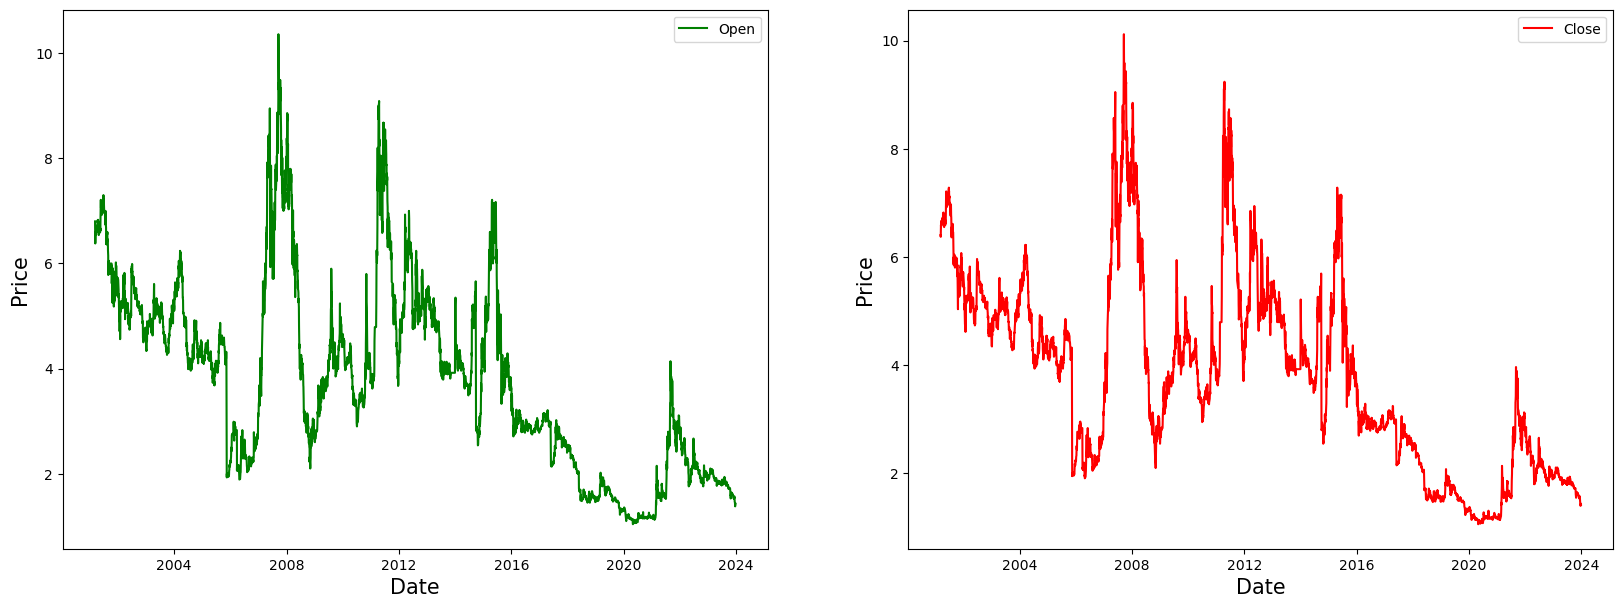

In [4]:
from matplotlib import pyplot as plt


fg,ax=plt.subplots(1,2,figsize=(20,7))
ax[0].plot(stock_data ['open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()
ax[1].plot(stock_data ['close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()
fg.show()

数据归一化处理

In [5]:
from sklearn.preprocessing import MinMaxScaler
# 创建缩放器
MMS = MinMaxScaler()
stock_data[stock_data.columns] = MMS.fit_transform(stock_data)

,open,high,low,close,preclose,volume
date,,,,,,
2001-03-09,0.618026,0.596875,0.600451,0.589857,0.455347,0.044924
2001-03-12,0.572961,0.558333,0.594808,0.586549,0.589857,0.005277
2001-03-13,0.575107,0.571875,0.604966,0.601985,0.586549,0.006637
2001-03-14,0.586910,0.571875,0.616253,0.604190,0.601985,0.003140
2001-03-15,0.589056,0.581250,0.613995,0.610805,0.604190,0.005796
...,...,...,...,...,...,...
2023-12-20,0.040773,0.037500,0.039503,0.037486,0.040794,0.056933
2023-12-21,0.036481,0.036458,0.037246,0.039691,0.037486,0.075178
2023-12-22,0.039700,0.037500,0.039503,0.040794,0.039691,0.058786


划分训练集和测试集

In [6]:
training_size = round(len(stock_data ) * 0.95)
train_data = stock_data[:training_size]
test_data  = stock_data[training_size:]

训练数据划分
创建训练和测试序列

In [7]:
import numpy as np


def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)):
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences), np.array(labels))

train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

创建LSTM模型

导入模块

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [9]:
print("训练数据形状：", train_seq.shape)
print("训练标签形状：", train_label.shape)
print("测试数据形状：", test_seq.shape)
print("测试标签形状：", test_label.shape)


训练数据形状： (5209, 50, 6)
训练标签形状： (5209, 6)
测试数据形状： (227, 50, 6)
测试标签形状： (227, 6)


建立模型

In [10]:

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(train_seq.shape[1], train_seq.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dense(6))  

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()
history = model.fit(train_seq, train_label, epochs=80, validation_data=(test_seq, test_label), verbose=1)





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            11400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                                 
Total params: 31906 (124.63 KB)
Trainable params: 31906 (124.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/80


163/163 [==============================] - 9s 31ms/step - loss: 0.0045 - mean_absolute_error: 0.0369 - val_loss: 2.1018e-04 - val_mean_


loss:  表示训练损失的值，这是模型在训练数据上的平均损失。这个值较小，表示模型在训练集上的拟合效果很好。

mean_absolute_error:  表示平均绝对误差的值，这是模型在训练数据上的平均绝对误差。这个值较小，说明模型对训练数据的拟合效果也很好。

val_loss:  表示验证损失的值，这是模型在验证集上的平均损失。这个值较小，说明模型在验证集上的性能良好。

val_mean_absolute_error:  表示验证集上的平均绝对误差。这个值较小，说明模型对验证数据的拟合效果很好。


In [13]:

# Print the training loss and metrics over epochs
print("训练损失Training Loss:", history.history['loss'])
print("平均绝对误差Training MAE:", history.history['mean_absolute_error'])
print("验证损失Validation Loss:", history.history['val_loss'])
print("平均绝对误差Validation MAE:", history.history['val_mean_absolute_error'])



训练损失Training Loss: [0.004502775613218546, 0.001273092464543879, 0.0010432632407173514, 0.0009597430471330881, 0.0008645622292533517, 0.0008063346613198519, 0.00068981375079602, 0.0006530872778967023, 0.0006251053418964148, 0.0005815664189867675, 0.0005536105600185692, 0.0005213373806327581, 0.0005049562896601856, 0.00047639774857088923, 0.00048643656191416085, 0.0004727203631773591, 0.00043164563248865306, 0.00043803968583233654, 0.0004371076647657901, 0.0004150230379309505, 0.0003972604463342577, 0.00037305860314518213, 0.00038369762478396297, 0.0003830942732747644, 0.0003859984572045505, 0.0003776366647798568, 0.0003885498153977096, 0.0003681214584503323, 0.0003759537066798657, 0.0003543497296050191, 0.0003524551575537771, 0.0003557975869625807, 0.0003544672217685729, 0.0003668939752969891, 0.0003452278033364564, 0.0003507339861243963, 0.00035578111419454217, 0.00033340812660753727, 0.0003419716958887875, 0.00034419490839354694, 0.0003488541697151959, 0.00033854827051982284, 0.000338

In [23]:
# Evaluate the model on the test set
loss, mean_absolute_error = model.evaluate(test_seq, test_label)
print(f'Test Loss: {loss}, Test Mean Absolute Error: {mean_absolute_error}')


8/8 [==============================] - 0s 13ms/step - loss: 9.5848e-05 - mean_absolute_error: 0.0039
Test Loss: 9.584799408912659e-05, Test Mean Absolute Error: 0.003907227888703346


可视化结果

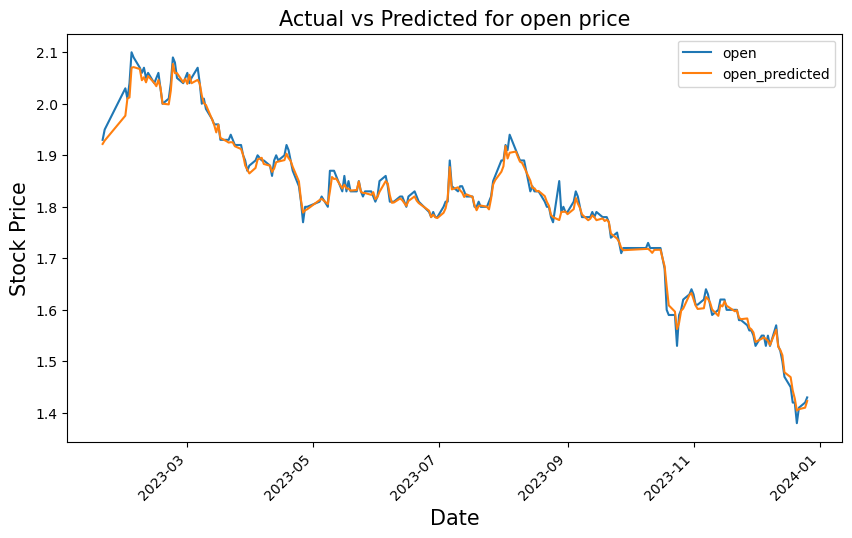

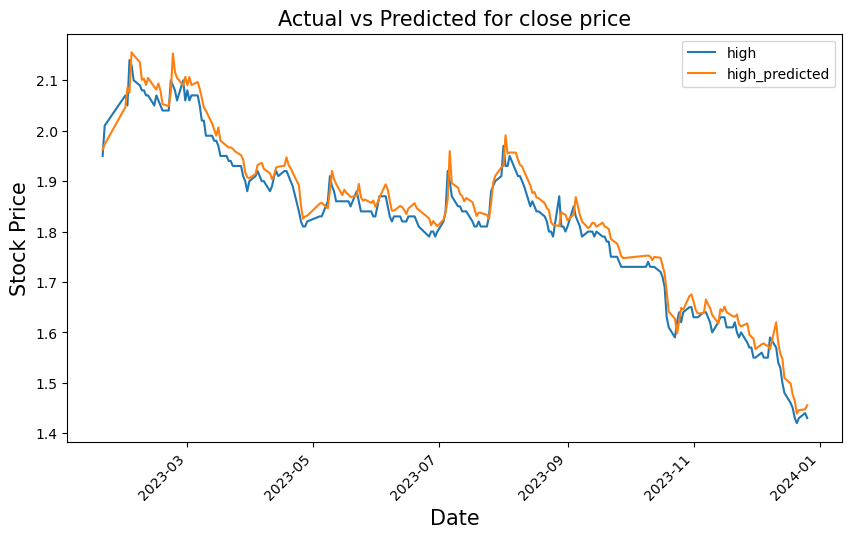

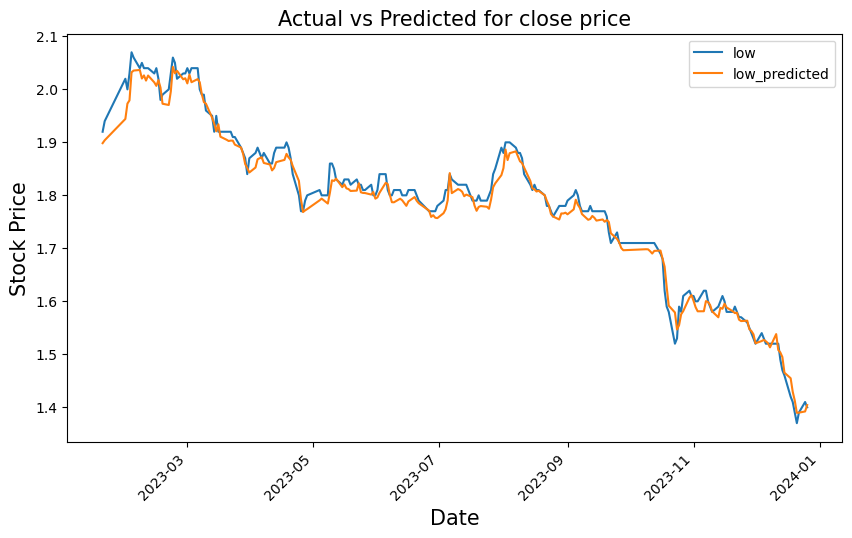

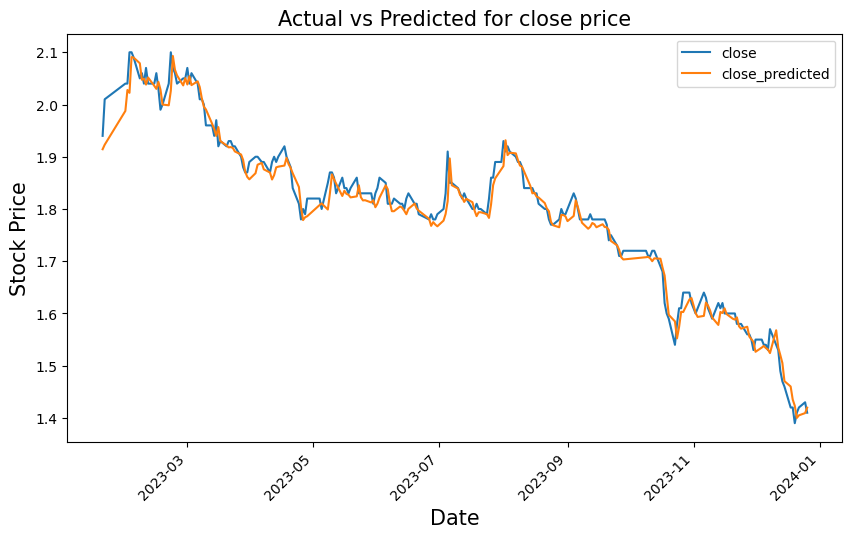

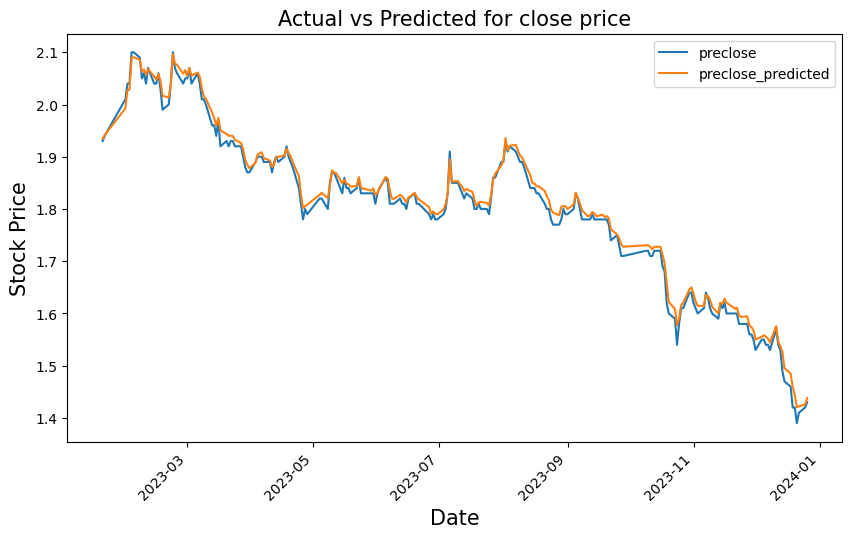

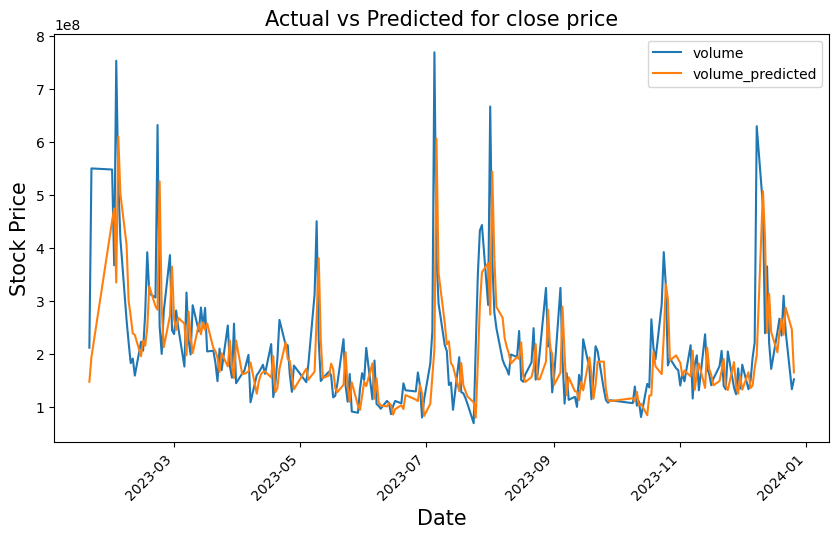

In [20]:
# Merging actual and predicted data for better visualization
# Continue with the rest of your code...
test_predicted = model.predict(test_seq)
test_inverse_predicted = MMS.inverse_transform(test_predicted)
gs_slic_data = pd.concat([stock_data.iloc[-227:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','high_predicted','low_predicted','close_predicted','preclose_predicted','volume_predicted'],index=stock_data.iloc[-227:].index)], axis=1)
gs_slic_data[['open','high','low','close','preclose','volume']] = MMS.inverse_transform(gs_slic_data[['open','high','low','close','preclose','volume']])
gs_slic_data.head()

gs_slic_data[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

gs_slic_data[['high','high_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

gs_slic_data[['low','low_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

gs_slic_data[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

gs_slic_data[['preclose','preclose_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

gs_slic_data[['volume','volume_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

In [28]:
gs_slic_data

,open,high,low,close,preclose,volume,open_predicted,high_predicted,low_predicted,close_predicted,preclose_predicted,volume_predicted
date,,,,,,,,,,,,
2023-01-19,1.93,1.95,1.92,1.94,1.93,211525023.0,1.922007,1.962277,1.898429,1.914388,1.934833,147239856.0
2023-01-20,1.95,2.01,1.94,2.01,1.94,549512438.0,1.928583,1.972953,1.903926,1.923016,1.941498,193767968.0
2023-01-30,2.03,2.07,2.02,2.04,2.01,547429370.0,1.976936,2.046777,1.944160,1.987671,1.992421,450289408.0
2023-01-31,2.01,2.05,2.00,2.04,2.04,366899452.0,2.010472,2.085494,1.973099,2.027759,2.027299,473956576.0
2023-02-01,2.04,2.14,2.03,2.10,2.04,752503916.0,2.012225,2.075304,1.979248,2.022353,2.028058,334261824.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,1.42,1.43,1.39,1.39,1.42,234248996.0,1.427858,1.464432,1.412558,1.423355,1.443683,265666048.0
2023-12-21,1.38,1.42,1.37,1.41,1.39,309316925.0,1.404577,1.439058,1.389504,1.400054,1.420596,235979808.0
2023-12-22,1.41,1.43,1.39,1.42,1.41,241871551.0,1.407214,1.445848,1.389843,1.405004,1.422119,286950560.0


预测实验

In [24]:
# Make predictions on the test set
predictions = model.predict(test_seq)


8/8 [==============================] - 0s 10ms/step


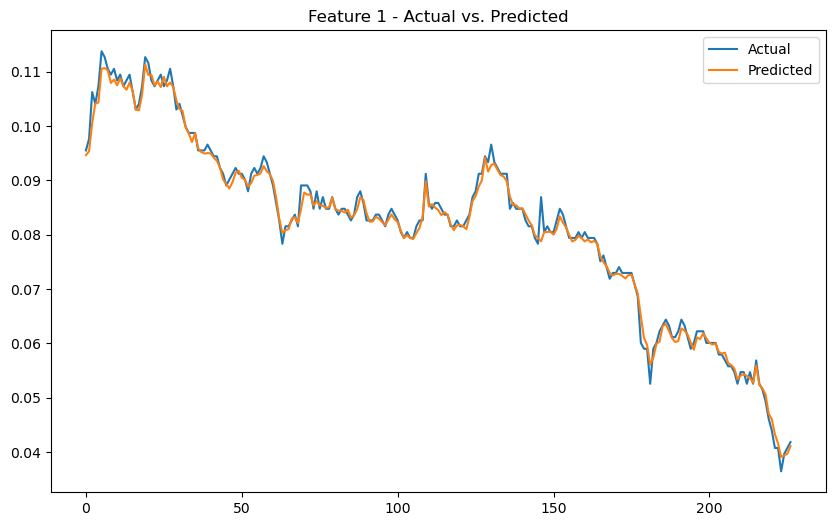

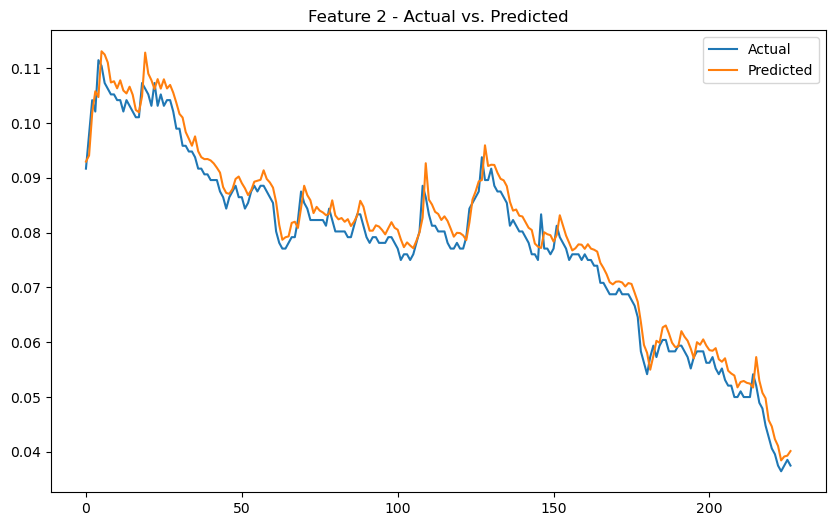

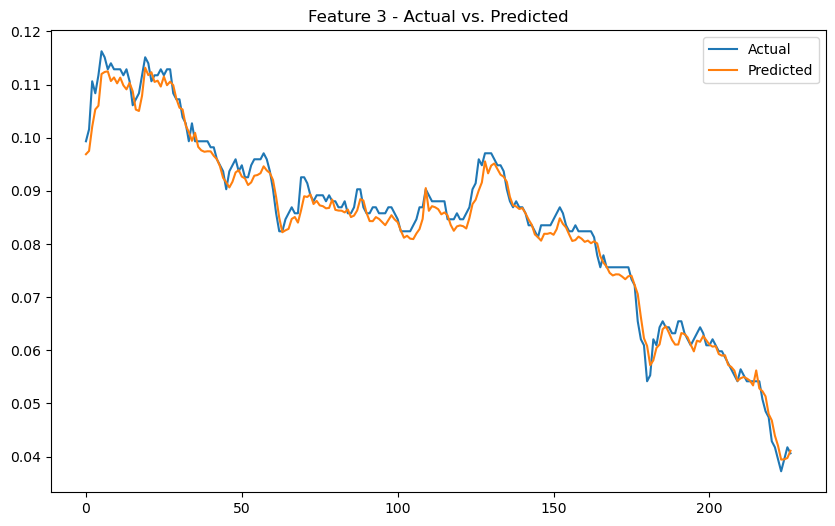

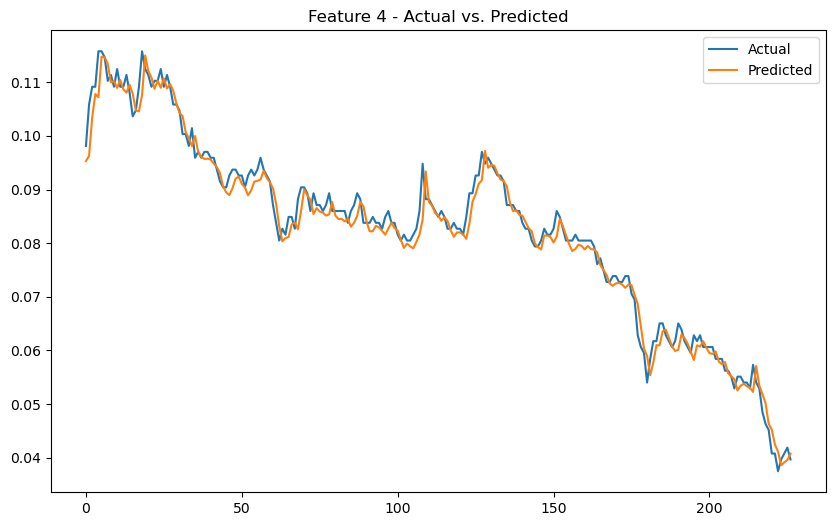

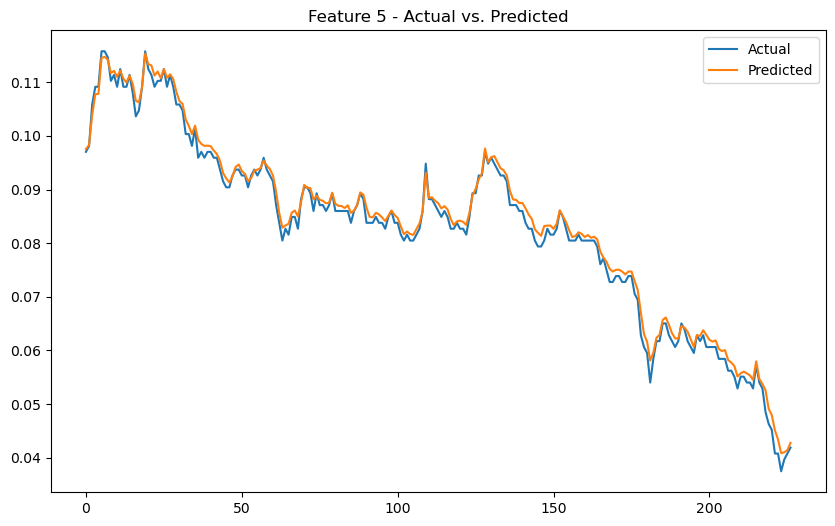

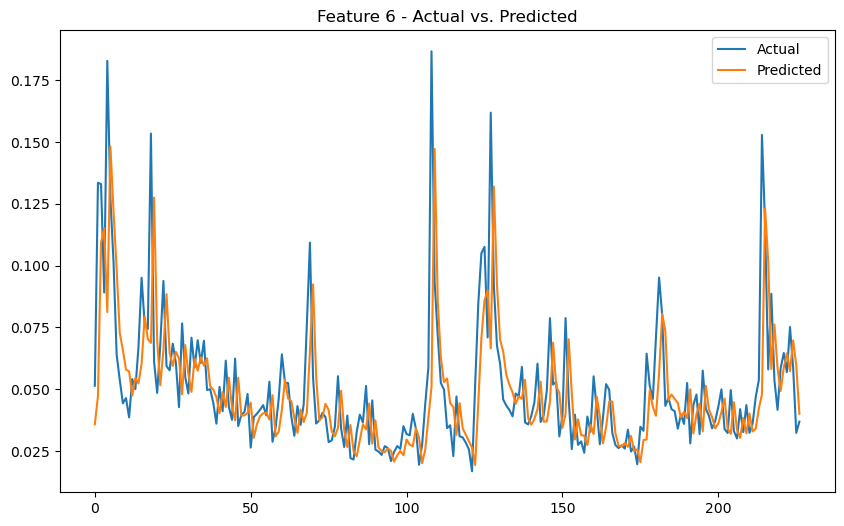

In [25]:
import matplotlib.pyplot as plt

# Assuming your data has 6 features (change if necessary)
num_features = 6

# Plotting actual vs. predicted values for each feature
for i in range(num_features):
    plt.figure(figsize=(10, 6))
    plt.plot(test_label[:, i], label='Actual')
    plt.plot(predictions[:, i], label='Predicted')
    plt.title(f'Feature {i+1} - Actual vs. Predicted')
    plt.legend()
    plt.show()


训练历史

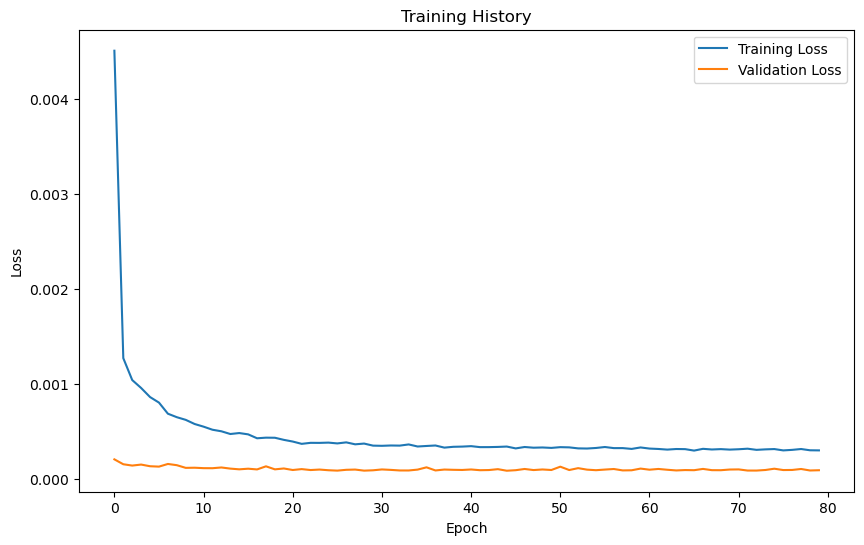

In [26]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
